In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df =pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('Submission.csv')

In [3]:
df.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
5,6,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176,0
6,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
7,8,Female,56,1,28.0,0,1-2 Year,Yes,32031.0,26.0,72,1
8,9,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28,0
9,10,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80,0


In [4]:
df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from imblearn.pipeline import Pipeline as ImbPipeline

# model building

In [7]:
# lets drop the id, Region_Code, Policy_Sales_Channel
df.drop(['id','Region_Code','Policy_Sales_Channel'], axis=1, inplace=True)

In [8]:
df.head(5)

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response
0,Male,44,1,0,> 2 Years,Yes,40454.0,217,1
1,Male,76,1,0,1-2 Year,No,33536.0,183,0
2,Male,47,1,0,> 2 Years,Yes,38294.0,27,1
3,Male,21,1,1,< 1 Year,No,28619.0,203,0
4,Female,29,1,1,< 1 Year,No,27496.0,39,0


In [9]:
# Handle categorical variables
categorical_features = ["Gender", "Vehicle_Age", "Vehicle_Damage"]
numerical_features = ["Age", "Driving_License", "Previously_Insured",  "Annual_Premium",  "Vintage"]

In [10]:
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [11]:
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

In [12]:
# Column transformer
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, numerical_features),
    ("cat", cat_transformer, categorical_features)
])

In [13]:
# Splitting data
X = df.drop(columns=["Response"])
y = df["Response"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
# place smote inside pipeline
model_pipeline = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", LogisticRegression(class_weight="balanced"))
    ]
)

In [16]:
def eval(model, X_train, X_test, y_train, y_test):

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    # confusion matrix for train and test
    train_cm = confusion_matrix(y_train, train_pred)
    test_cm = confusion_matrix(y_test, test_pred)
    print("Train Confusion Matrix:")
    print(train_cm)
    print("\nTest Confusion Matrix:")
    print(test_cm)

    #classification report for training and testing
    train_cr = classification_report(y_train, train_pred)
    test_cr = classification_report(y_test, test_pred)
    print("\nTrain Classification Report:")
    print(train_cr)
    print("\nTest Classification Report:")
    print(test_cr)

    #f1 score for training and testing
    train_f1 = f1_score(y_train, train_pred)
    test_f1 = f1_score(y_test, test_pred)
    print("\nTrain F1 Score:", train_f1)
    print("Test F1 Score:", test_f1)

    # auc_roc score for training and testing
    train_auc = roc_auc_score(y_train, train_pred)
    test_auc = roc_auc_score(y_test, test_pred)
    print("\nTrain AUC-ROC Score:", train_auc)
    print("Test AUC-ROC Score:", test_auc)

    #auc_roc curve
    train_fpr, train_tpr, _ = roc_curve(y_train, train_pred)
    test_fpr, test_tpr, _ = roc_curve(y_test, test_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(train_fpr, train_tpr, label='Train AUC-ROC (area = %0.2f)' % train_auc)
    plt.plot(test_fpr, test_tpr, label='Test AUC-ROC (area = %0.2f)' % test_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [17]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Driving_License',
                                                   'Previously_Insured',
                                                   'Annual_Premium',
                                                   'Vintage']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Vehicle_Age',
                                                   'Vehicle_Damage'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', LogisticRegression(class_weight='balanced'))])

Train Confusion Matrix:
[[158507 109012]
 [  1014  36354]]

Test Confusion Matrix:
[[39712 27168]
 [  237  9105]]

Train Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    267519
           1       0.25      0.97      0.40     37368

    accuracy                           0.64    304887
   macro avg       0.62      0.78      0.57    304887
weighted avg       0.90      0.64      0.70    304887


Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.59      0.74     66880
           1       0.25      0.97      0.40      9342

    accuracy                           0.64     76222
   macro avg       0.62      0.78      0.57     76222
weighted avg       0.90      0.64      0.70     76222


Train F1 Score: 0.3978898289316712
Test F1 Score: 0.3992107859256824

Train AUC-ROC Score: 0.7826859655245995
Test AUC-ROC Score: 0.7842053021852231


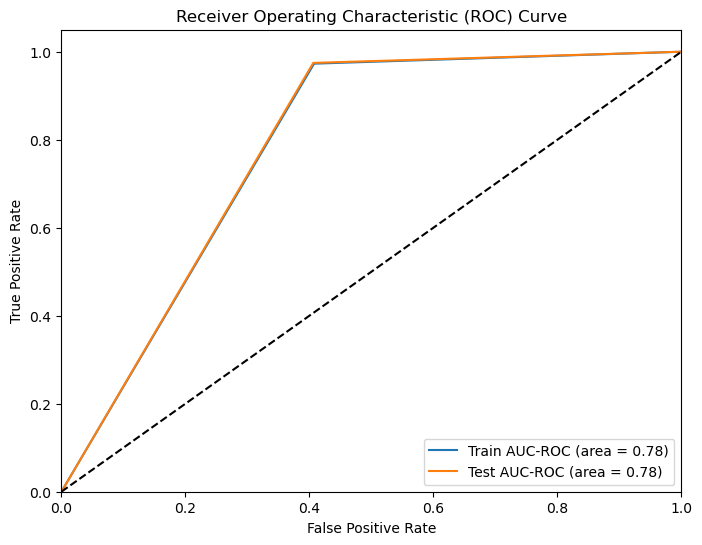

In [18]:
eval(model_pipeline, X_train, X_test, y_train, y_test)

In [19]:
# lets predict on test data
sub['Response'] = model_pipeline.predict(test)

In [20]:
sub.to_csv('submmission1.csv',index=False)

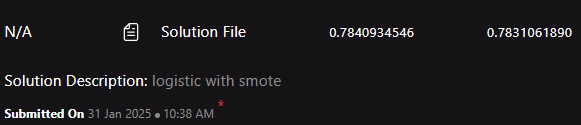

In [22]:
model_pipeline1 = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", RandomForestClassifier())
    ]
)

In [23]:
model_pipeline1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Driving_License',
                                                   'Previously_Insured',
                                                   'Annual_Premium',
                                                   'Vintage']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Vehicle_Age',
                                                   'Vehicle_Damage'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', RandomForestClassifier())])

Train Confusion Matrix:
[[265990   1529]
 [  1163  36205]]

Test Confusion Matrix:
[[57885  8995]
 [ 5574  3768]]

Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    267519
           1       0.96      0.97      0.96     37368

    accuracy                           0.99    304887
   macro avg       0.98      0.98      0.98    304887
weighted avg       0.99      0.99      0.99    304887


Test Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89     66880
           1       0.30      0.40      0.34      9342

    accuracy                           0.81     76222
   macro avg       0.60      0.63      0.61     76222
weighted avg       0.84      0.81      0.82     76222


Train F1 Score: 0.9641554153018562
Test F1 Score: 0.34091834426600315

Train AUC-ROC Score: 0.9815808161086611
Test AUC-ROC Score: 0.6344225693580158


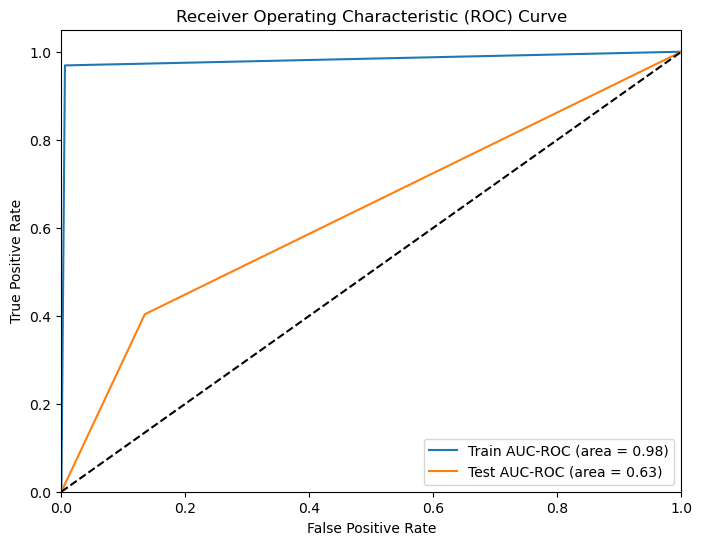

In [24]:
eval(model_pipeline1, X_train, X_test, y_train, y_test)

In [25]:
sub['Response'] = model_pipeline1.predict(test)

In [26]:
sub.to_csv('submmission2.csv',index=False)

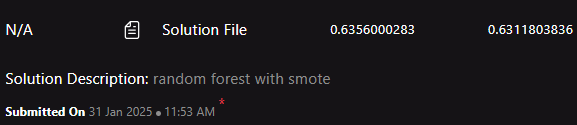

# applying decission tree calsifier

In [29]:
model_pipeline2 = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", DecisionTreeClassifier())
    ]
)

In [30]:
model_pipeline2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Driving_License',
                                                   'Previously_Insured',
                                                   'Annual_Premium',
                                                   'Vintage']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Vehicle_Age',
                                                   'Vehicle_Damage'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', DecisionTreeClassifier())])

Train Confusion Matrix:
[[267119    400]
 [  2285  35083]]

Test Confusion Matrix:
[[58906  7974]
 [ 6423  2919]]

Train Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    267519
           1       0.99      0.94      0.96     37368

    accuracy                           0.99    304887
   macro avg       0.99      0.97      0.98    304887
weighted avg       0.99      0.99      0.99    304887


Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     66880
           1       0.27      0.31      0.29      9342

    accuracy                           0.81     76222
   macro avg       0.58      0.60      0.59     76222
weighted avg       0.82      0.81      0.82     76222


Train F1 Score: 0.9631439513527611
Test F1 Score: 0.2885100074128984

Train AUC-ROC Score: 0.9686781013889078
Test AUC-ROC Score: 0.5966156949015559


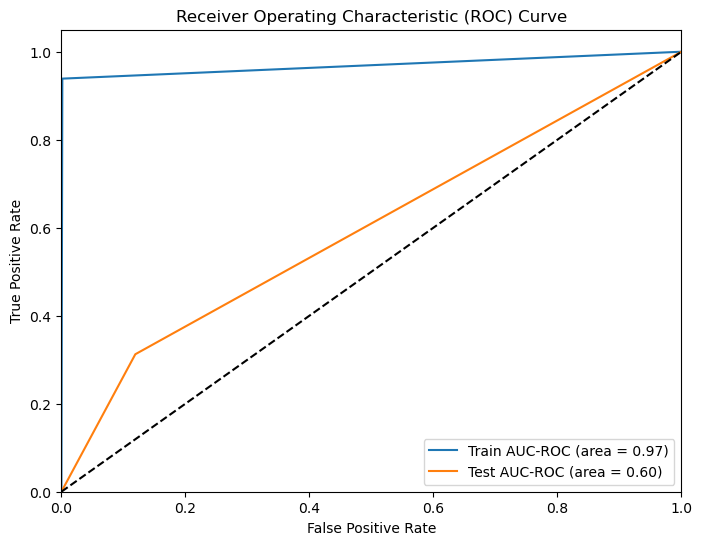

In [31]:
eval(model_pipeline2, X_train, X_test, y_train, y_test)

In [32]:
sub['Response'] = model_pipeline2.predict(test)

In [33]:
sub.to_csv('submmission3.csv',index=False)

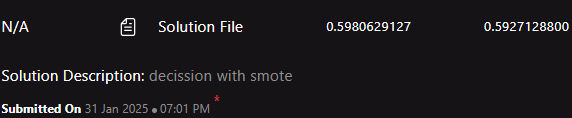

# lets check with KNN clasifier 


In [36]:
model_pipeline3 = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", KNeighborsClassifier())
    ]
)

In [37]:
model_pipeline3.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Driving_License',
                                                   'Previously_Insured',
                                                   'Annual_Premium',
                                                   'Vintage']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Vehicle_Age',
                                                   'Vehicle_Damage'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', KNeighborsClassifier())])

Train Confusion Matrix:
[[220587  46932]
 [   966  36402]]

Test Confusion Matrix:
[[51424 15456]
 [ 3626  5716]]

Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90    267519
           1       0.44      0.97      0.60     37368

    accuracy                           0.84    304887
   macro avg       0.72      0.90      0.75    304887
weighted avg       0.93      0.84      0.87    304887


Test Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.77      0.84     66880
           1       0.27      0.61      0.37      9342

    accuracy                           0.75     76222
   macro avg       0.60      0.69      0.61     76222
weighted avg       0.85      0.75      0.79     76222


Train F1 Score: 0.6031714470348462
Test F1 Score: 0.3746477026938455

Train AUC-ROC Score: 0.8993573681378119
Test AUC-ROC Score: 0.690379968429862


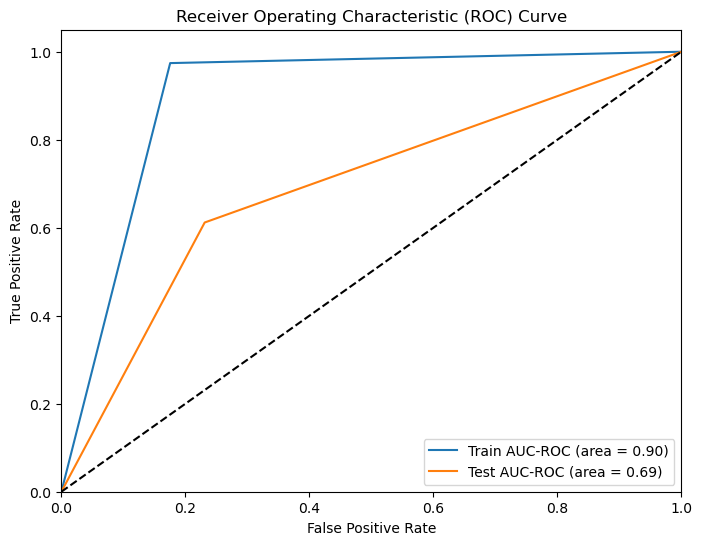

In [38]:
eval(model_pipeline3, X_train, X_test, y_train, y_test)

In [39]:
sub['Response'] = model_pipeline3.predict(test)

In [40]:
sub.to_csv('submmission4.csv',index=False)

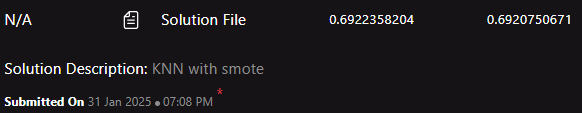

# apply Adaboost classifier 

In [43]:
model_pipeline4 = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", AdaBoostClassifier())
    ]
)

In [44]:
model_pipeline4.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Driving_License',
                                                   'Previously_Insured',
                                                   'Annual_Premium',
                                                   'Vintage']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Vehicle_Age',
                                                   'Vehicle_Damage'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', AdaBoostClassifier())])

Train Confusion Matrix:
[[178414  89105]
 [  3324  34044]]

Test Confusion Matrix:
[[44688 22192]
 [  814  8528]]

Train Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.67      0.79    267519
           1       0.28      0.91      0.42     37368

    accuracy                           0.70    304887
   macro avg       0.63      0.79      0.61    304887
weighted avg       0.90      0.70      0.75    304887


Test Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.67      0.80     66880
           1       0.28      0.91      0.43      9342

    accuracy                           0.70     76222
   macro avg       0.63      0.79      0.61     76222
weighted avg       0.90      0.70      0.75     76222


Train F1 Score: 0.4241793704093647
Test F1 Score: 0.42574010284059705

Train AUC-ROC Score: 0.7889838696275123
Test AUC-ROC Score: 0.7905242210155506


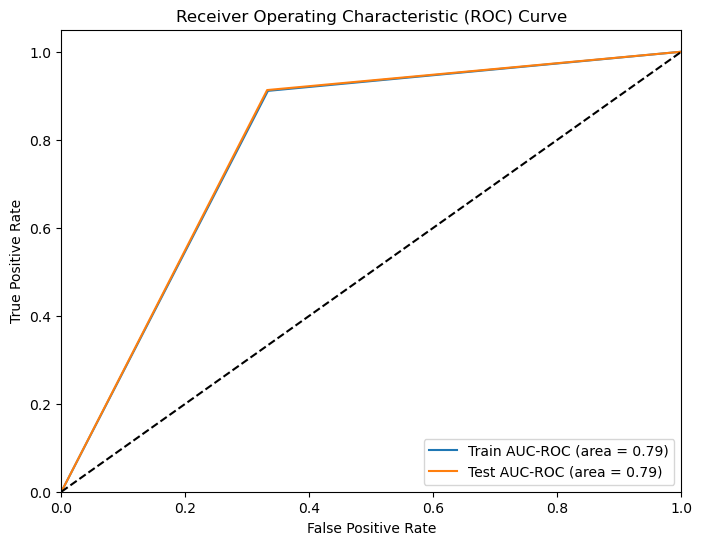

In [45]:
eval(model_pipeline4, X_train, X_test, y_train, y_test)

In [46]:
sub['Response'] = model_pipeline4.predict(test)

In [47]:
sub.to_csv('submmission5.csv',index=False)

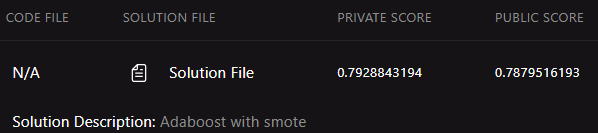

# apply XGB classifier 

In [50]:
model_pipeline5 = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", XGBClassifier())
    ]
)

In [51]:
model_pipeline5.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Driving_License',
                                                   'Previously_Insured',
                                                   'Annual_Premium',
                                                   'Vintage']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

Train Confusion Matrix:
[[188587  78932]
 [  4278  33090]]

Test Confusion Matrix:
[[46973 19907]
 [ 1300  8042]]

Train Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.70      0.82    267519
           1       0.30      0.89      0.44     37368

    accuracy                           0.73    304887
   macro avg       0.64      0.80      0.63    304887
weighted avg       0.89      0.73      0.77    304887


Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.70      0.82     66880
           1       0.29      0.86      0.43      9342

    accuracy                           0.72     76222
   macro avg       0.63      0.78      0.62     76222
weighted avg       0.89      0.72      0.77     76222


Train F1 Score: 0.4430015395943504
Test F1 Score: 0.4313105038749296

Train AUC-ROC Score: 0.7952325398370316
Test AUC-ROC Score: 0.7815954952501386


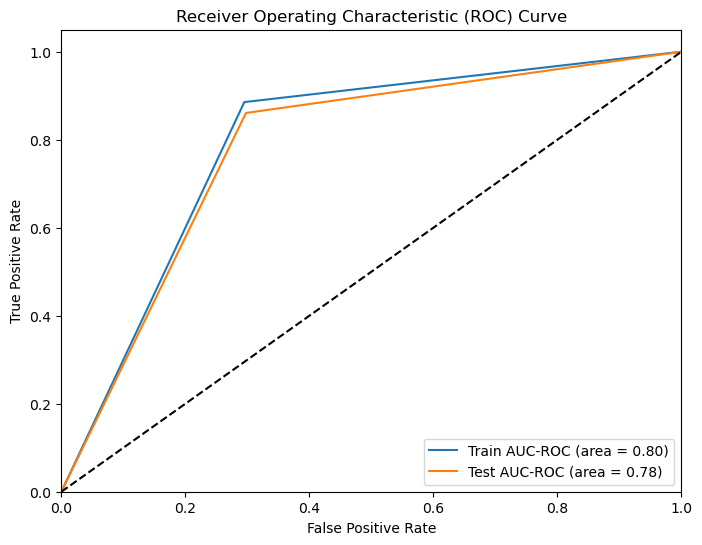

In [52]:
eval(model_pipeline5, X_train, X_test, y_train, y_test)

In [53]:
sub['Response'] = model_pipeline5.predict(test)
sub.to_csv('submmission6.csv',index=False)

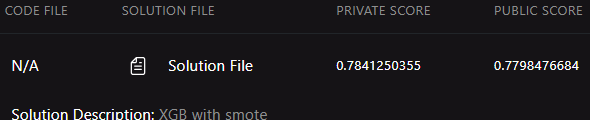

# apply catboost classifier 

In [56]:
model_pipeline6 = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", CatBoostClassifier())
    ]
)

In [57]:
model_pipeline6.fit(X_train, y_train)

Learning rate set to 0.150645
0:	learn: 0.5789713	total: 189ms	remaining: 3m 9s
1:	learn: 0.5183687	total: 279ms	remaining: 2m 19s
2:	learn: 0.4835862	total: 366ms	remaining: 2m 1s
3:	learn: 0.4597540	total: 456ms	remaining: 1m 53s
4:	learn: 0.4462022	total: 540ms	remaining: 1m 47s
5:	learn: 0.4382441	total: 637ms	remaining: 1m 45s
6:	learn: 0.4304231	total: 727ms	remaining: 1m 43s
7:	learn: 0.4250260	total: 852ms	remaining: 1m 45s
8:	learn: 0.4201493	total: 960ms	remaining: 1m 45s
9:	learn: 0.4154190	total: 1.07s	remaining: 1m 45s
10:	learn: 0.4122807	total: 1.16s	remaining: 1m 44s
11:	learn: 0.4095261	total: 1.26s	remaining: 1m 43s
12:	learn: 0.4071615	total: 1.35s	remaining: 1m 42s
13:	learn: 0.4035452	total: 1.46s	remaining: 1m 43s
14:	learn: 0.4007072	total: 1.61s	remaining: 1m 45s
15:	learn: 0.3976625	total: 1.71s	remaining: 1m 45s
16:	learn: 0.3952582	total: 1.79s	remaining: 1m 43s
17:	learn: 0.3943639	total: 1.87s	remaining: 1m 42s
18:	learn: 0.3924241	total: 1.96s	remaining: 1

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Driving_License',
                                                   'Previously_Insured',
                                                   'Annual_Premium',
                                                   'Vintage']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Vehicle_Age',
                                                   'Vehicle_Damage'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x000002038DE09150>)])

Train Confusion Matrix:
[[214845  52674]
 [ 10913  26455]]

Test Confusion Matrix:
[[53355 13525]
 [ 3122  6220]]

Train Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.80      0.87    267519
           1       0.33      0.71      0.45     37368

    accuracy                           0.79    304887
   macro avg       0.64      0.76      0.66    304887
weighted avg       0.88      0.79      0.82    304887


Test Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.80      0.87     66880
           1       0.32      0.67      0.43      9342

    accuracy                           0.78     76222
   macro avg       0.63      0.73      0.65     76222
weighted avg       0.87      0.78      0.81     76222


Train F1 Score: 0.45417478561679697
Test F1 Score: 0.4276824698318837

Train AUC-ROC Score: 0.7555302584910187
Test AUC-ROC Score: 0.7317912240880564


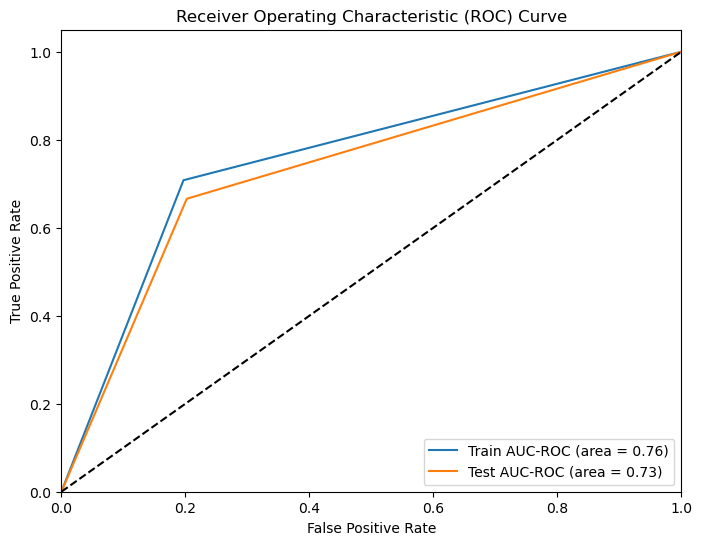

In [58]:
eval(model_pipeline6, X_train, X_test, y_train, y_test)

In [59]:
sub['Response'] = model_pipeline6.predict(test)
sub.to_csv('submmission7.csv',index=False)

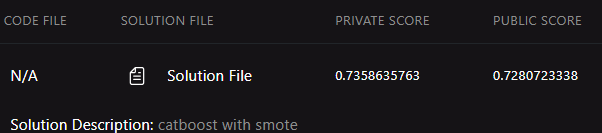

# applying lightGBM classifier

In [71]:
! pip install lightgbm

In [72]:
from lightgbm import LGBMClassifier

In [73]:
model_pipeline7 = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", LGBMClassifier())
    ]
)

In [74]:
model_pipeline7.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 267519, number of negative: 267519
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 535038, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Driving_License',
                                                   'Previously_Insured',
                                                   'Annual_Premium',
                                                   'Vintage']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Vehicle_Age',
                                                   'Vehicle_Damage'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', LGBMClassifier())])

Train Confusion Matrix:
[[193456  74063]
 [  6119  31249]]

Test Confusion Matrix:
[[48409 18471]
 [ 1518  7824]]

Train Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.72      0.83    267519
           1       0.30      0.84      0.44     37368

    accuracy                           0.74    304887
   macro avg       0.63      0.78      0.63    304887
weighted avg       0.89      0.74      0.78    304887


Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.72      0.83     66880
           1       0.30      0.84      0.44      9342

    accuracy                           0.74     76222
   macro avg       0.63      0.78      0.63     76222
weighted avg       0.89      0.74      0.78     76222


Train F1 Score: 0.4380291561536305
Test F1 Score: 0.43909419984847214

Train AUC-ROC Score: 0.7796994518901428
Test AUC-ROC Score: 0.7806634040818898


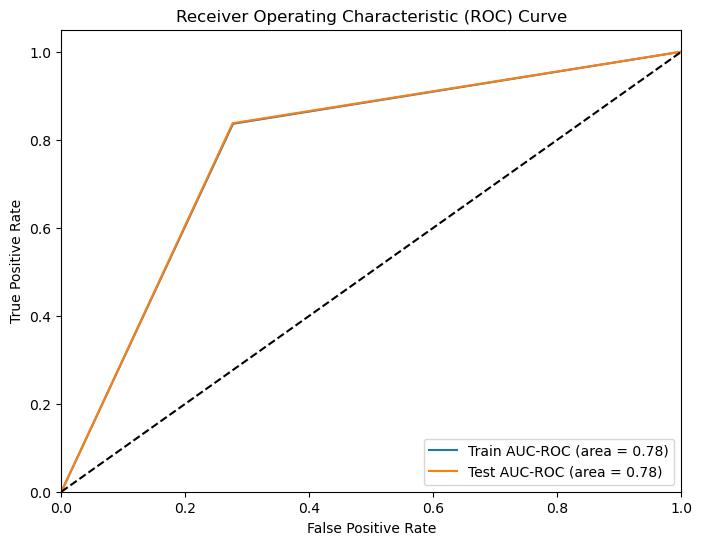

In [75]:
eval(model_pipeline7, X_train, X_test, y_train, y_test)

# applying gradient boosting classifier

In [77]:
model_pipeline8 = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", GradientBoostingClassifier())
    ]
)

In [78]:
model_pipeline8.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Driving_License',
                                                   'Previously_Insured',
                                                   'Annual_Premium',
                                                   'Vintage']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Vehicle_Age',
                                                   'Vehicle_Damage'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', GradientBoostingClassifier())])

Train Confusion Matrix:
[[180806  86713]
 [  3521  33847]]

Test Confusion Matrix:
[[45268 21612]
 [  864  8478]]

Train Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.68      0.80    267519
           1       0.28      0.91      0.43     37368

    accuracy                           0.70    304887
   macro avg       0.63      0.79      0.61    304887
weighted avg       0.90      0.70      0.75    304887


Test Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.68      0.80     66880
           1       0.28      0.91      0.43      9342

    accuracy                           0.71     76222
   macro avg       0.63      0.79      0.62     76222
weighted avg       0.90      0.71      0.76     76222


Train F1 Score: 0.42863836685071677
Test F1 Score: 0.4300060864272671

Train AUC-ROC Score: 0.790818634925355
Test AUC-ROC Score: 0.792184258926349


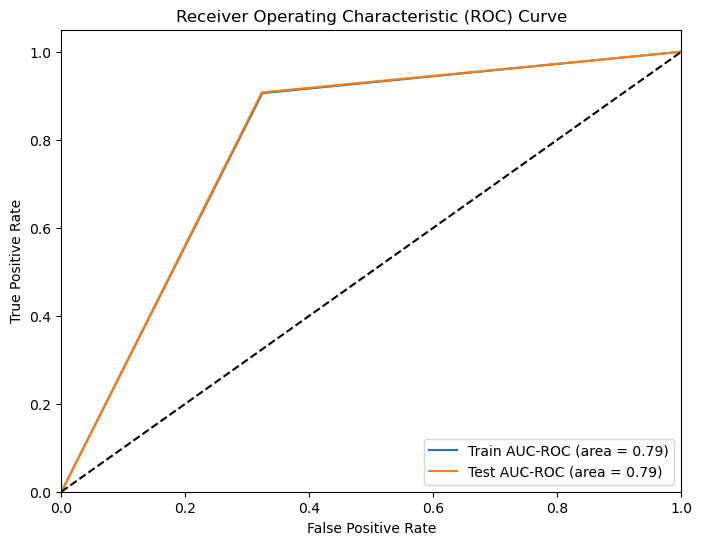

In [79]:
eval(model_pipeline8, X_train, X_test, y_train, y_test)

# apply SMOTETomek on adaboost, xgboost, catboost, gradient, LGB

In [81]:
from imblearn.combine import SMOTETomek

In [82]:
model_pipeline9 = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTETomek()),
        ("classifier", AdaBoostClassifier())
    ]
)

In [83]:
model_pipeline9.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Driving_License',
                                                   'Previously_Insured',
                                                   'Annual_Premium',
                                                   'Vintage']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Vehicle_Age',
                                                   'Vehicle_Damage'])])),
                ('smote', SMOTETomek()), ('classifier', AdaBoostClassifier())])

Train Confusion Matrix:
[[174211  93308]
 [  2718  34650]]

Test Confusion Matrix:
[[43624 23256]
 [  654  8688]]

Train Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.65      0.78    267519
           1       0.27      0.93      0.42     37368

    accuracy                           0.69    304887
   macro avg       0.63      0.79      0.60    304887
weighted avg       0.90      0.69      0.74    304887


Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.65      0.78     66880
           1       0.27      0.93      0.42      9342

    accuracy                           0.69     76222
   macro avg       0.63      0.79      0.60     76222
weighted avg       0.90      0.69      0.74     76222


Train F1 Score: 0.4191718181048352
Test F1 Score: 0.4208690597296904

Train AUC-ROC Score: 0.789236894891178
Test AUC-ROC Score: 0.7911331523325743


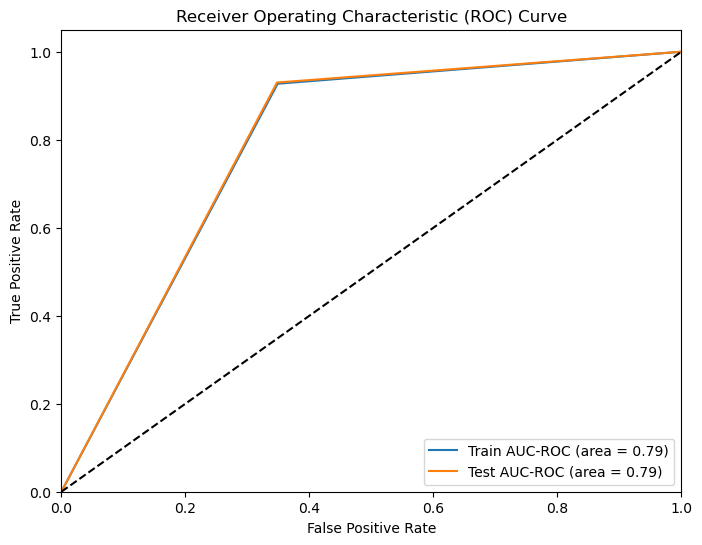

In [84]:
eval(model_pipeline9, X_train, X_test, y_train, y_test)

# apply ensumble techniques bagging, voting, stacking

In [86]:
# base classifiers
rf_classifier = RandomForestClassifier(random_state=42)
xgb_classifier = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
lgbm_classifier = LGBMClassifier(random_state=42)
cat_classifier = CatBoostClassifier(random_state=42, verbose=0)
ada_classifier = AdaBoostClassifier(random_state=42)

# applying votting 

In [88]:
voting_classifier = VotingClassifier(
    estimators=[
        ('rfc',rf_classifier),
        ('XGB',xgb_classifier),
        ('lgbm',lgbm_classifier),
        ('cat',cat_classifier),
        ('ada',ada_classifier)
    ],
    voting='soft'
)

In [89]:
voting_pipeline = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTETomek(random_state=42)),
        ("classifier", voting_classifier)
    ]
)

In [90]:
voting_pipeline.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 258517, number of negative: 258517
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 517034, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Driving_License',
                                                   'Previously_Insured',
                                                   'Annual_Premium',
                                                   'Vintage']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown...
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...)),
                                              ('lgbm',
                                               LGBMClassifier(random_state=42)),
                                              ('cat',
                                               <catboost.core.CatBoostClassifier object at 0x000002039496B090>),
                                              ('ada',
                                               AdaBoostClassifier(random_state=42))],
                                  voting='soft'))])

Train Confusion Matrix:
[[217712  49807]
 [  3478  33890]]

Test Confusion Matrix:
[[51348 15532]
 [ 2385  6957]]

Train Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.81      0.89    267519
           1       0.40      0.91      0.56     37368

    accuracy                           0.83    304887
   macro avg       0.69      0.86      0.73    304887
weighted avg       0.91      0.83      0.85    304887


Test Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.77      0.85     66880
           1       0.31      0.74      0.44      9342

    accuracy                           0.76     76222
   macro avg       0.63      0.76      0.64     76222
weighted avg       0.88      0.76      0.80     76222


Train F1 Score: 0.5598645355800603
Test F1 Score: 0.43712104552166126

Train AUC-ROC Score: 0.8603722716993171
Test AUC-ROC Score: 0.7562322533211642


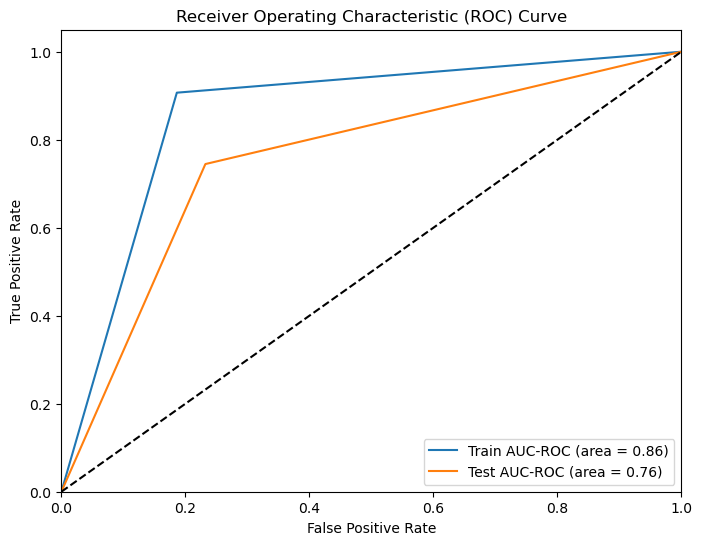

In [91]:
eval(voting_pipeline, X_train, X_test, y_train, y_test)

In [92]:
xgb_classifier = XGBClassifier(random_state=42,  eval_metric='logloss')
lgbm_classifier = LGBMClassifier(random_state=42, class_weight='balanced')
cat_classifier = CatBoostClassifier(random_state=42, auto_class_weights='Balanced', verbose=0)
ada_classifier = AdaBoostClassifier(random_state=42)

In [93]:
# Stacking Classifier
stacking_classifier = StackingClassifier(
    estimators=[
        ('ada', ada_classifier),
        ('xgb', xgb_classifier),
        ('lgbm', lgbm_classifier),
        ('cat', cat_classifier)
    ],
    final_estimator=CatBoostClassifier(random_state=42, verbose=0)
)

In [94]:
stacking_pipeline = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42, sampling_strategy=0.5)),
        ("classifier", stacking_classifier)
    ]
)

In [95]:
stacking_pipeline.fit(X_train,y_train)

[LightGBM] [Info] Number of positive: 133759, number of negative: 267519
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the train set: 401278, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 107007, number of negative: 214015
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 831
[LightGBM] [Info] Number of data points in the train set: 321022, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Driving_License',
                                                   'Previously_Insured',
                                                   'Annual_Premium',
                                                   'Vintage']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown...
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=None,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=42, ...)),
                                                ('lgbm',
                                                 LGBMClassifier(class_weight='balanced',
                                                                random_state=42)),
                                                ('cat',
                                                 <catboost.core.CatBoostClassifier object at 0x0000020394B6B990>)],
                                    final_estimator=<catboost.core.CatBoostClassifier object at 0x0000020395192A50>))])

Train Confusion Matrix:
[[244418  23101]
 [ 24729  12639]]

Test Confusion Matrix:
[[60985  5895]
 [ 6419  2923]]

Train Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91    267519
           1       0.35      0.34      0.35     37368

    accuracy                           0.84    304887
   macro avg       0.63      0.63      0.63    304887
weighted avg       0.84      0.84      0.84    304887


Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91     66880
           1       0.33      0.31      0.32      9342

    accuracy                           0.84     76222
   macro avg       0.62      0.61      0.62     76222
weighted avg       0.83      0.84      0.84     76222


Train F1 Score: 0.345762433659791
Test F1 Score: 0.3219162995594713

Train AUC-ROC Score: 0.6259389132867021
Test AUC-ROC Score: 0.6123725449787398


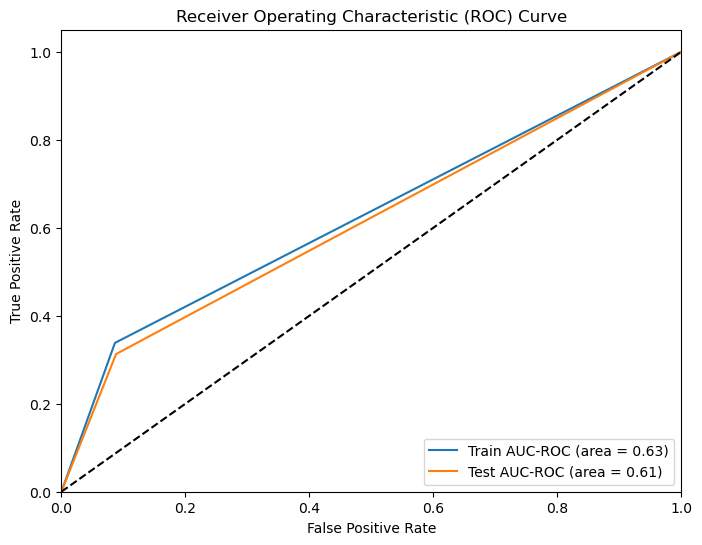

In [96]:
eval(stacking_pipeline, X_train, X_test, y_train, y_test)

In [97]:
lr_classifier = LogisticRegression(class_weight="balanced")

In [98]:
# Bagging Classifier
bagging_classifier = BaggingClassifier(
    base_estimator=lr_classifier,
    n_estimators=10,
    random_state=42
)


In [99]:
bagging_pipeline = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTETomek(random_state=42)),
        ("classifier", bagging_classifier)
    ]
)

In [100]:
bagging_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Driving_License',
                                                   'Previously_Insured',
                                                   'Annual_Premium',
                                                   'Vintage']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Vehicle_Age',
                                                   'Vehicle_Damage'])])),
                ('smote', SMOTETomek(random_state=42)),
                ('classifier',
                 BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced'),
                                   random_state=42))])

Train Confusion Matrix:
[[158473 109046]
 [   997  36371]]

Test Confusion Matrix:
[[39708 27172]
 [  234  9108]]

Train Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    267519
           1       0.25      0.97      0.40     37368

    accuracy                           0.64    304887
   macro avg       0.62      0.78      0.57    304887
weighted avg       0.90      0.64      0.70    304887


Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.59      0.74     66880
           1       0.25      0.97      0.40      9342

    accuracy                           0.64     76222
   macro avg       0.62      0.78      0.57     76222
weighted avg       0.90      0.64      0.70     76222


Train F1 Score: 0.3979648220587028
Test F1 Score: 0.3992810486168953

Train AUC-ROC Score: 0.7828498859880859
Test AUC-ROC Score: 0.7843359630684699


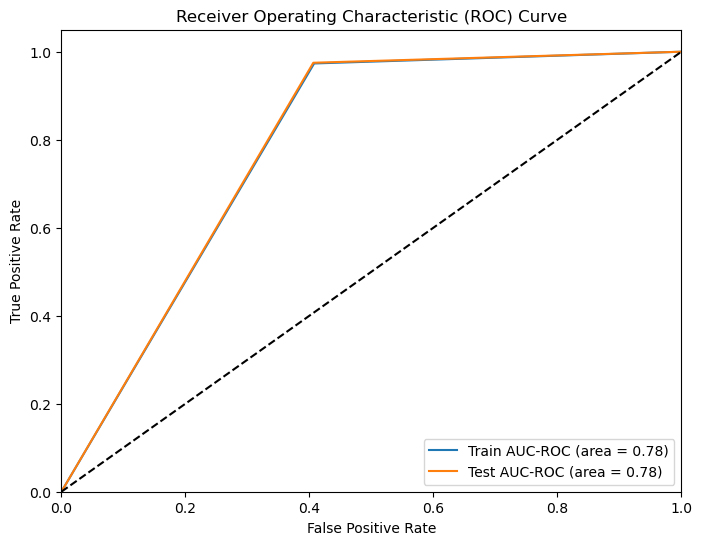

In [101]:
eval(bagging_pipeline, X_train, X_test, y_train, y_test)

# hyper perameter tuning for adaboost 

In [ ]:
param_grid = {
    'classifier__n_estimators': [100,150],  # Number of boosting rounds
    'classifier__max_depth': [2,3,4,5],          # Maximum depth of a tree
    'classifier__learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'classifier__gamma': [0, 0.1, 0.2],          # Minimum loss reduction required to make a split
    'classifier__reg_alpha': [0, 0.1, 0.5],      # L1 regularization term on weights
    'classifier__reg_lambda': [0, 0.1, 0.5]      # L2 regularization term on weights
}